In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr, permutation_resampling
from tools import savefig, fix_figure, coef_var, corrcoef
import copy
from IPython.display import display
import statsmodels.api as sm

rc = {
    'figure.figsize' : (9, 9),
    'axes.labelsize' : 25,
    'lines.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'axes.titlesize' : 20,
    'font.size'      : 20,
    'legend.frameon' : False,
    'legend.fontsize': 20,
    'font.family'    : 'serif',
#     'font.serif'     : Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
#     'font.sans-serif': Helvetica, Avant Garde, Computer Modern Sans serif
#     'font.cursive'   : Zapf Chancery
#     'font.monospace' : Courier, Computer Modern Typewriter
    'text.usetex'    : False}
sns.set(rc=rc)
sns.set_color_codes()
sns.set_style('white')
plt.rcParams.update(rc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
analys = pd.read_csv('results/params_AI_analyse.csv')
# analys = pd.read_csv('results/params_SI_analyse.csv')
# analys = pd.read_csv('results/params_A~I_analyse.csv')
# analys = pd.read_csv('results/params_AI_longstim_analyse.csv')
# analys = pd.read_csv('results/params_AI_regstim_analyse.csv')
# analys = pd.read_csv('results/params_AI_reglongstim_analyse.csv')

In [5]:
analys['cch$_{ptrans}$'] = analys['trans_prob']

In [6]:
analys.loc[(analys.pfast > 0.001) & (analys.pcausal > 0.001),'cch$_{ptrans}$'] = np.nan

In [7]:
analys.keys()

Index(['cc', 'cmax', 'logreg', 'logreg_intercept', 'logreg_ns',
       'logreg_ns_intercept', 'n_syn', 'pcausal', 'pfast', 'ptime', 'source',
       'source_cv', 'source_pop', 'stim_amp', 'target', 'target_cv',
       'target_pop', 'trans_prob', 'wald', 'wald_ns', 'weight',
       'cch$_{ptrans}$'],
      dtype='object')

In [8]:
state = pd.concat([
    analys.loc[:,['cc']], 
    analys.drop_duplicates('source').loc[:,['source_cv']],
    analys.drop_duplicates('target').loc[:,['target_cv']]], 
    axis=1)

In [9]:
state.describe()

,cc,source_cv,target_cv
count,239799.000000,601.000000,399.000000
mean,0.218908,0.358547,0.591588
std,0.096189,0.094803,0.149510
min,0.021862,0.227955,0.289873
25%,0.147074,0.303555,0.471949
50%,0.204515,0.334761,0.610450
75%,0.275090,0.374045,0.712914
max,0.603035,0.853258,0.907046


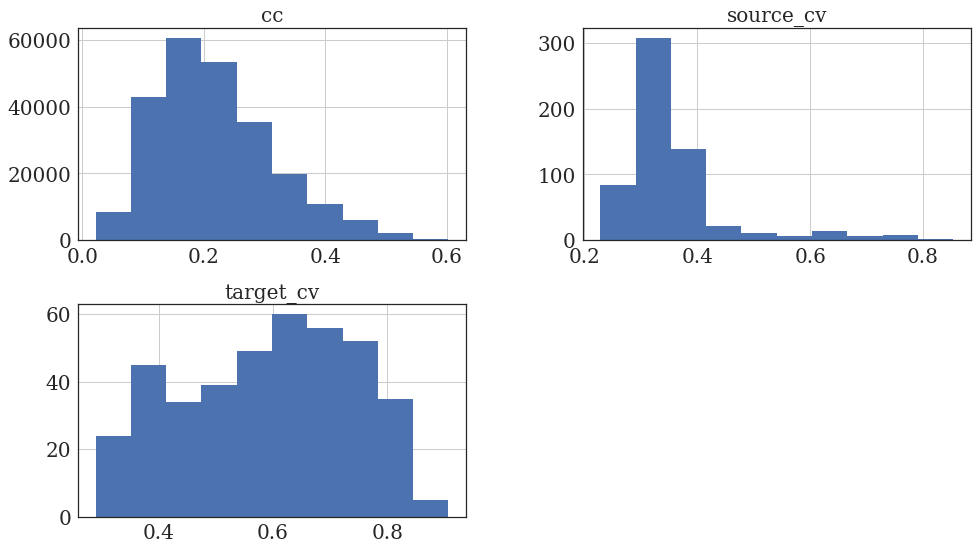

In [10]:
state.hist();

In [11]:
def model(x):
    return 1/(1+np.exp(-x))

def norm(x):
#     return (x - np.mean(x)) / np.std(x)
    return (x - min(x)) / (max(x) - min(x))

In [12]:
analys['logit'] = model(analys.logreg + analys.logreg_intercept)
analys['wald$_c$'] = analys['wald'] - analys['wald_ns']
analys['logreg$_c$'] = analys['logreg'] - analys['logreg_ns']
analys['wald$_{cut}$'] = analys['wald']

analys.loc[analys['wald$_{cut}$'] < 0,'wald$_{cut}$'] = 0
analys['weight$_{norm}$'] = norm(analys['weight'])

analys['wald$_{cut}^c$'] = analys['wald$_c$']
analys.loc[analys['wald$_{cut}^c$'] < 0,'wald$_{cut}^c$'] = 0

analys['wald$_{cut}^{ns}$'] = analys['wald_ns']
analys.loc[analys['wald$_{cut}^{ns}$'] < 0,'wald$_{cut}^{ns}$'] = 0

analys['cch$_{cut}$'] = analys['cch$_{ptrans}$']
analys.loc[analys['cch$_{cut}$'] < 0,'cch$_{cut}$'] = 0

In [13]:
# analys.loc[analys.pfast > 0.001,'wald$_{cut}$'] = np.nan
# analys.loc[analys.pfast > 0.001,'logit'] = np.nan

In [14]:
# analys = analys.loc[analys.stim_amp >= 5.]

# False positives

In [34]:
def label_diff(x1, x2, y, text, color='k'):
    h = y * .01
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color=color)
    plt.text((x1 + x2) * .5, y + h, text, ha='center', va='bottom', color=color)

In [35]:
fn = pd.DataFrame()
TOL = 0.05
wald = 'wald$_{cut}$'

fn['wald'] = analys.loc[analys.weight == 0, wald]
fn['logit'] = analys.loc[analys.weight == 0, 'logit']
fn['cch'] = analys.loc[analys.weight == 0, 'cch$_{ptrans}$']

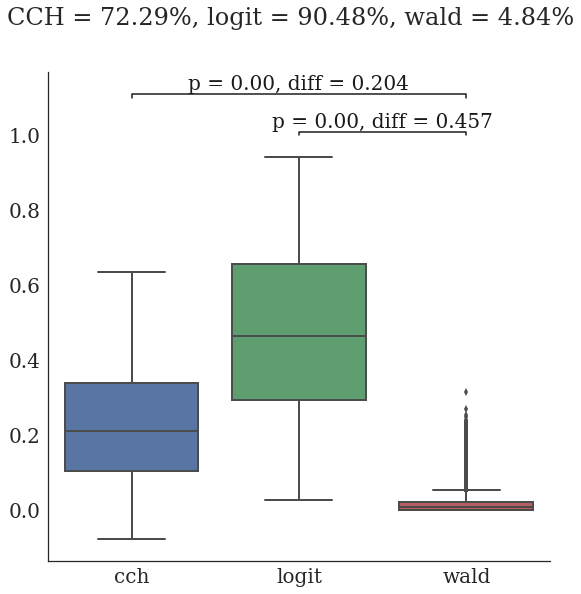

In [36]:
sns.boxplot(data=fn.loc[:,['cch','logit', 'wald']])
for key, pos_x, pos_y in zip(['cch','logit'], [0, 1], [1.1, 1.0]):
    case = fn.loc[:,['wald']].dropna().values.flatten()
    control = fn.loc[:,[key]].dropna().values.flatten()
    pval, observed_diff, diffs = permutation_resampling(case, control, 1000, statistic=np.median)
    label_diff(pos_x, 2, pos_y, 'p = {:.2f}, diff = {:.3f}'.format(pval, observed_diff))
N = analys.shape[0] / 100
plt.suptitle('CCH = {:.2f}%, logit = {:.2f}%, wald = {:.2f}%'.format(
    sum(fn.cch > 0.05)/N, sum(fn.logit > 0.05)/N, sum(fn.wald > 0.05)/N))
sns.despine()
savefig(plt.gcf(), 'false_positive')

In [18]:
interest = ['source', 'target', 'weight', 'stim_amp', 'n_syn', 
            'wald$_{cut}$', 'cc', 'wald', 'wald_ns', 'wald$_{cut}^{ns}$']

In [19]:
analys.loc[(analys['wald'] > TOL) 
           , interest].sort_values('target', ascending=False)

,source,target,weight,stim_amp,n_syn,wald$_{cut}$,cc,wald,wald_ns,wald$_{cut}^{ns}$
193913,486,1000,0.000000,9.162554,0,0.103184,0.226669,0.103184,-0.003230,0.000000
137255,344,1000,0.000000,7.031634,0,0.054825,0.244816,0.054825,0.004627,0.004627
59051,148,1000,0.000000,5.575638,0,0.065350,0.258013,0.065350,0.053666,0.053666
29525,74,1000,0.000000,9.721565,0,0.076310,0.218454,0.076310,0.018446,0.018446
25535,64,1000,0.000000,4.326423,0,0.071730,0.305316,0.071730,-0.013289,0.000000
128078,321,1000,0.000000,6.655604,0,0.059085,0.243967,0.059085,-0.003230,0.000000
51470,129,1000,0.000000,9.159452,0,0.052718,0.222585,0.052718,-0.004963,0.000000
69026,173,1000,0.000000,6.028898,0,0.053407,0.249845,0.053407,0.007703,0.007703
144038,361,1000,0.000778,5.495576,1,0.069095,0.273833,0.069095,-0.013278,0.000000
94562,237,1000,0.000000,8.247911,0,0.056640,0.230850,0.056640,0.026776,0.026776


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d36bd66d8>,
      dtype=object)

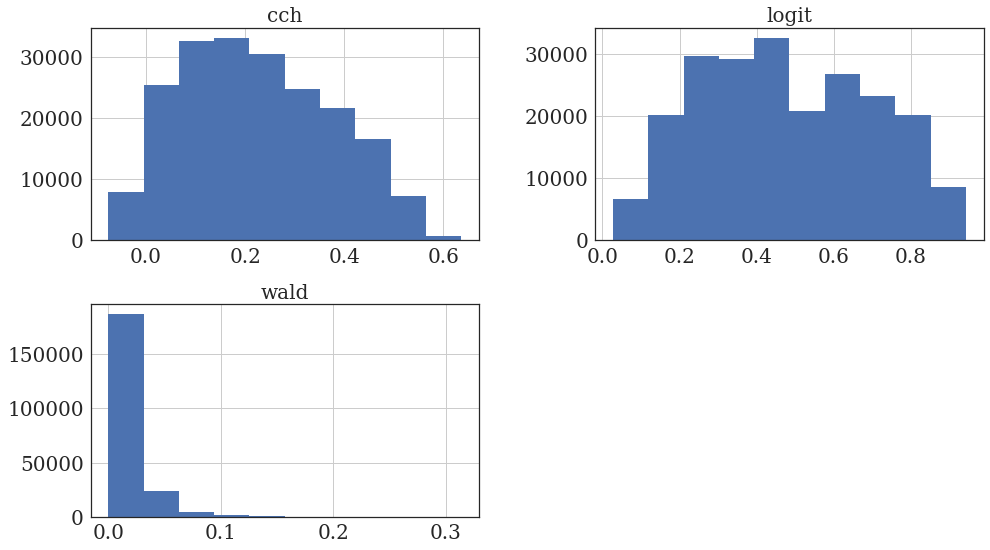

In [20]:
fn.hist()

# False negatives

In [37]:
fn = pd.DataFrame()
TOL = 0.05
fn['wald'] = analys.loc[(analys['wald$_{cut}$'] < TOL) & (analys.weight > TOL), 'weight']
fn['logit'] = analys.loc[(analys['logit'] < TOL) & (analys.weight > TOL), 'weight']
fn['cch'] = analys.loc[(analys['cch$_{ptrans}$'] < TOL) & (analys.weight > TOL), 'weight']

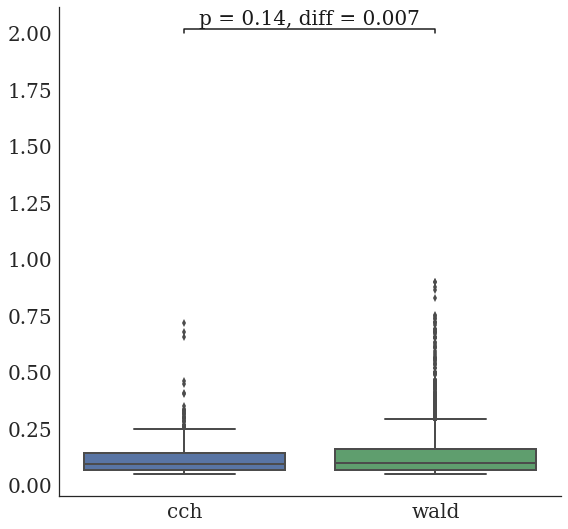

In [38]:
sns.boxplot(data=fn.loc[:,['cch', 'wald']])
for key, pos_x, pos_y in zip(['cch'], [0, 1], [2.0, 1.9]):
    case = fn.loc[:,['wald']].dropna().values.flatten()
    control = fn.loc[:,[key]].dropna().values.flatten()
    pval, observed_diff, diffs = permutation_resampling(case, control, 1000, statistic=np.nanmedian)
    label_diff(pos_x, 1, pos_y, 'p = {:.2f}, diff = {:.3f}'.format(pval, observed_diff))
sns.despine()
savefig(plt.gcf(), 'false_negative')

# Goodness of fit

In [23]:
w = analys[analys.weight>0].sort_values('weight').reset_index(drop=True).dropna()

In [24]:
def regplot(x, y, data, model, ci, scatter_color='b', model_color='k', ax=None, 
            scatter_kws={}, regplot_kws={}, 
            xlabel=True, ylabel=True, **kwargs):
    
    from seaborn import utils
    from seaborn import algorithms as algo
    if ax is None:
        fig, ax = plt.subplots()
    _x = data[x]
    _y = data[y]
    grid = np.linspace(_x.min(), _x.max(), 100)
    
    X = np.c_[np.ones(len(_x)), _x]
    G = np.c_[np.ones(len(grid)), grid]
    
    results = model(_y, X, **kwargs).fit()
    
    def reg_func(xx, yy):
        yhat = model(yy, xx, **kwargs).fit().predict(G)
        return yhat
    yhat = results.predict(G)
    yhat_boots = algo.bootstrap(X, _y, func=reg_func,
                                n_boot=1000, units=None)
    err_bands = utils.ci(yhat_boots, ci, axis=0)
    ax.plot(grid, yhat, color=model_color, **regplot_kws)
    ax.scatter(_x, _y, color=scatter_color, **scatter_kws)
    ax.fill_between(grid, *err_bands, facecolor=model_color, alpha=.15)
    if xlabel:
        if isinstance(xlabel, str):
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(x)
    if ylabel:
        if isinstance(ylabel, str):
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(y)
    return results

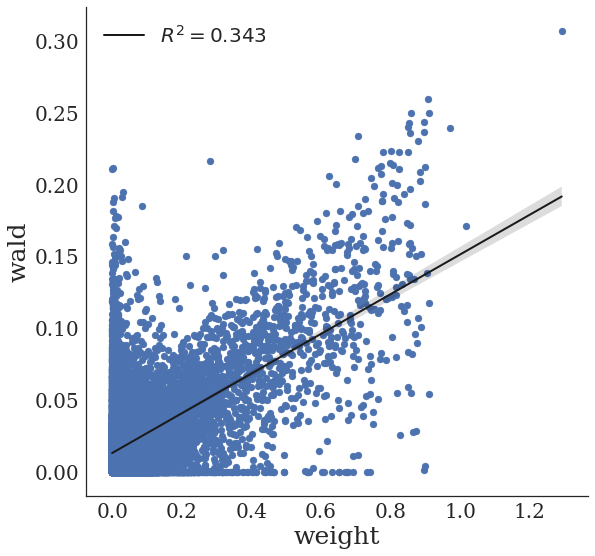

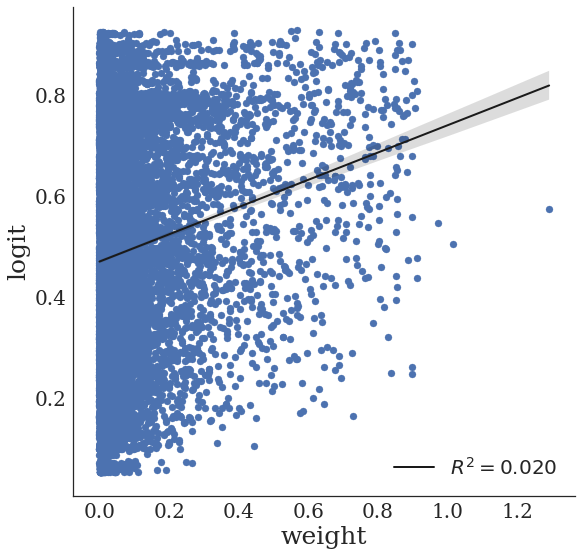

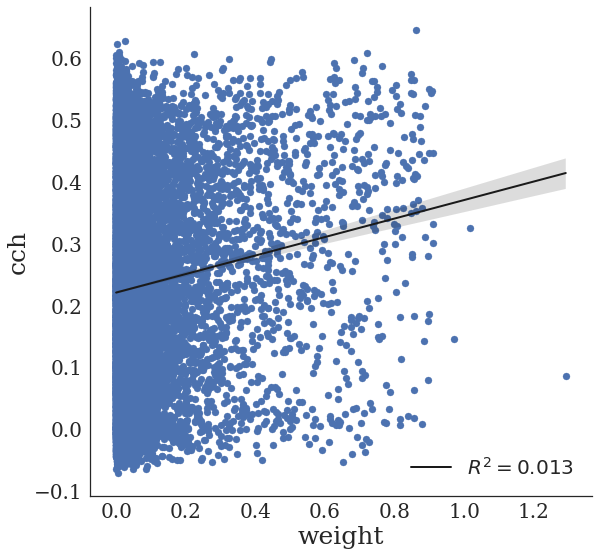

In [31]:
model = sm.OLS
ci = 95.
figsize = (9,9)

fig, ax = plt.subplots(1, 1, figsize=figsize)
wald = regplot(x='weight', y='wald$_{cut}$', data=w, 
               model=model, ci=ci, ax=ax,
               ylabel='wald')
h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(wald.rsquared), ls='-', color='k')
plt.legend(handles=[h])
sns.despine()
savefig(plt.gcf(), 'fit_wald')

fig, ax = plt.subplots(1, 1, figsize=figsize)
logit = regplot(x='weight', y='logit', data=w, 
                model=model, ci=ci, ax=ax,
               ylabel='logit')
h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(logit.rsquared), ls='-', color='k')
plt.legend(handles=[h])
sns.despine()
savefig(plt.gcf(), 'fit_logit')

fig, ax = plt.subplots(1, 1, figsize=figsize)
cch = regplot(x='weight', y='cch$_{ptrans}$', data=w, 
             model=model, ci=ci, ax=ax,
             ylabel='cch')
h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(cch.rsquared), ls='-', color='k')
plt.legend(handles=[h])
sns.despine()
savefig(plt.gcf(), 'fit_cch')

In [26]:
wald.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           wald$_{cut}$   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.104e+04
Date:                Wed, 14 Mar 2018   Prob (F-statistic):               0.00
Time:                        12:57:47   Log-Likelihood:                 50695.
No. Observations:               21149   AIC:                        -1.014e+05
Df Residuals:                   21147   BIC:                        -1.014e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.000     77.068      0.000       0.013       0.013
x1             0.1383      0.001    105.090      0.000       0.136       0.141
==============================================================================
Omnibus:                     8060.148   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57637.098
Skew:                           1.659   Prob(JB):                         0.00
Kurtosis:                      10.375   Cond. No.                         8.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  logit   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     439.5
Date:                Wed, 14 Mar 2018   Prob (F-statistic):           1.32e-96
Time:                        12:57:47   Log-Likelihood:                 2483.6
No. Observations:               21149   AIC:                            -4963.
Df Residuals:                   21147   BIC:                            -4947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4702      0.002    287.749      0.000       0.467       0.473
x1             0.2697      0.013     20.965      0.000       0.244       0.295
==============================================================================
Omnibus:                     5974.988   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              964.621
Skew:                           0.068   Prob(JB):                    3.43e-210
Kurtosis:                       1.963   Cond. No.                         8.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
cch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         cch$_{ptrans}$   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     276.7
Date:                Wed, 14 Mar 2018   Prob (F-statistic):           9.78e-62
Time:                        12:57:48   Log-Likelihood:                 10028.
No. Observations:               21149   AIC:                        -2.005e+04
Df Residuals:                   21147   BIC:                        -2.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2208      0.001    193.062      0.000       0.219       0.223
x1             0.1498      0.009     16.634      0.000       0.132       0.167
==============================================================================
Omnibus:                     2502.366   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.230
Skew:                           0.205   Prob(JB):                    2.08e-173
Kurtosis:                       2.143   Cond. No.                         8.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Residuals

In [29]:
pval, observed_diff, diffs = permutation_resampling(
     wald.resid, logit.resid, 10000, np.median)
print(pval, observed_diff)

0.0 0.006560898396252388


In [30]:
pval, observed_diff, diffs = permutation_resampling(
     wald.resid, cch.resid, 10000, np.median)
print(pval, observed_diff)

0.0003 0.003765124751520868


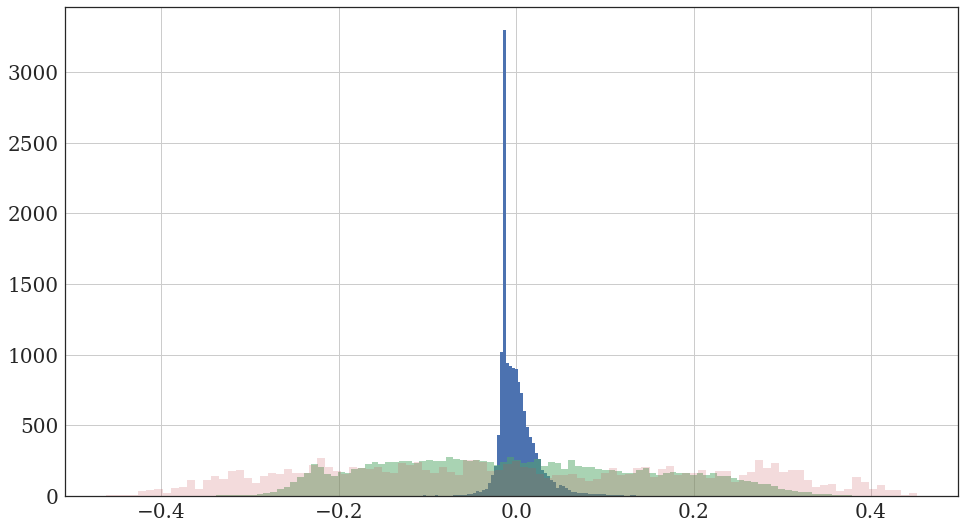

In [86]:
wald.resid.hist(bins=100)
cch.resid.hist(bins=100, alpha=.5)
logit.resid.hist(bins=100, alpha=.2)